In [1]:
import geopandas as gpd 
import matplotlib.pyplot as plt
import xarray as xr 
import rioxarray as rxr 
from pathlib import Path
from metpy import calc as mpcalc
from metpy.units import units as mpunits
import numpy as np
from scipy.interpolate import griddata

In [2]:
basin = "EastRiver"

In [3]:
root_path = Path("/storage/dlhogan/summa_modeling_data/")

In [4]:
basin_gdf = gpd.read_file(root_path / f"domain_{basin}" / "shapefiles" / "catchment" / f"{basin}.shp")

In [41]:
pres_era5_ds = xr.open_dataset(root_path / f"domain_{basin}" / "forcing" / "1_raw_data" / "ERA5_surface_pressure_2011_2024.nc")['sp']


<xarray.DataArray 'sp' (valid_time: 113952, latitude: 9, longitude: 9)> Size: 37MB
[9230112 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 912kB 2011-01-01 ... 2023-12-31T2...
  * latitude    (latitude) float64 72B 40.0 39.75 39.5 39.25 ... 38.5 38.25 38.0
  * longitude   (longitude) float64 72B -107.0 -106.8 -106.5 ... -105.2 -105.0
    expver      (valid_time) <U4 2MB ...
Attributes: (12/32)
    GRIB_paramId:                             134
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      81
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               Pa
    long_name:                                Surface pressure
    units:                                    Pa
    standard_name:                            surface_air_pressure
    GRIB_surface:                             0.0

In [64]:
# open ERA5 surface pressure data
pres_era5_ds = xr.open_dataset(root_path / f"domain_{basin}" / "forcing" / "1_raw_data" / "ERA5_surface_pressure_2011_2024.nc")['sp']

# pull in ERA5 geopotential
z_era5_ds = xr.open_dataset(root_path / f"domain_{basin}" / "forcing" / "0_geopotential" / f"ERA5_surface_geopotential_height_{basin}.nc")['z']

# pull in gridmet elevation data
elev_gridmet_ds = xr.open_dataset(root_path / f"gridmet_metdata_elevationdata.nc")['elevation']

# add crs to all datasets
pres_era5_ds = pres_era5_ds.rio.write_crs("epsg:4326")
z_era5_ds = z_era5_ds.rio.write_crs("epsg:4326")
elev_gridmet_ds = elev_gridmet_ds.rio.write_crs("epsg:4326")

# rename elev_gridmet_ds, z_era5_ds, and pres_era5_ds lat and lon to y and x
elev_gridmet_ds = elev_gridmet_ds.rename({'lat': 'y','lon': 'x'})
z_era5_ds = z_era5_ds.rename({'latitude': 'y','longitude': 'x'})
pres_era5_ds = pres_era5_ds.rename({'latitude': 'y','longitude': 'x'})

# clip elev_gridmet_ds to the basin total bounds
z_era5_ds = z_era5_ds.rio.clip_box(*basin_gdf.total_bounds)
pres_era5_ds = pres_era5_ds.rio.clip_box(*basin_gdf.total_bounds)
elev_gridmet_ds = elev_gridmet_ds.rio.clip_box(*basin_gdf.total_bounds)

# convert z_era5_ds and pres_era5_ds x and y to the outer corners of the grid cells
z_era5_ds['x'] = np.array([z_era5_ds['x'].min() - np.sqrt(2) * 0.25, z_era5_ds['x'].max() + np.sqrt(2) * 0.25])
z_era5_ds['y'] = np.array([z_era5_ds['y'].min() - np.sqrt(2) * 0.25, z_era5_ds['y'].max() + np.sqrt(2) * 0.25])


In [65]:
# extract coordinates
lon_era5, lat_era5 = np.meshgrid(z_era5_ds.x, z_era5_ds.y)
lon_gridmet, lat_gridmet = np.meshgrid(elev_gridmet_ds.x, elev_gridmet_ds.y)

# Flatten coordinate arrays
points_era5 = np.array([lon_era5.flatten(), lat_era5.flatten()]).T

In [66]:
# ---- Vectorized Interpolation ----
def vectorized_downscaling(data_era5, elev_4km, method='cubic'):
    """
    Performs vectorized downscaling using bicubic interpolation and elevation correction.
    """
    time_steps = len(data_era5['valid_time'])
    P_values = data_era5.values.reshape(time_steps, -1)  # Flatten W over space

    # Perform bicubic interpolation for all time steps
    interpolated_P = np.stack([
        griddata(points_era5, P_values[t, :], (lon_gridmet, lat_gridmet), method=method)
        for t in range(time_steps)
    ])

    # Interpolate elevation
    interpolated_elev_1deg = griddata(points_era5, z_era5_ds.values.flatten(), (lon_gridmet, lat_gridmet), method=method)
    # Elevation difference (km)
    delta_elev_m = (elev_4km - interpolated_elev_1deg)
    # Apply elevation-based correction using 
    interpolated_P = mpcalc.add_height_to_pressure(interpolated_P * mpunits("pascal"), delta_elev_m * mpunits("meter"))

    return interpolated_P

In [71]:
surface_pressure = vectorized_downscaling(pres_era5_ds, elev_gridmet_ds)

In [73]:
# convert to xarray and add time, x, and y coordinates
surface_pressure_ds = xr.DataArray(surface_pressure.magnitude, dims=['valid_time', 'y', 'x'], coords={'valid_time': pres_era5_ds.valid_time, 'y': elev_gridmet_ds.y, 'x': elev_gridmet_ds.x})

In [74]:
# save to netcdf
surface_pressure_ds.to_netcdf(root_path / f"domain_{basin}" / "forcing" / "1_raw_data" / f"ERA5_surface_pressure_{basin}_4km_2011_2024.nc")

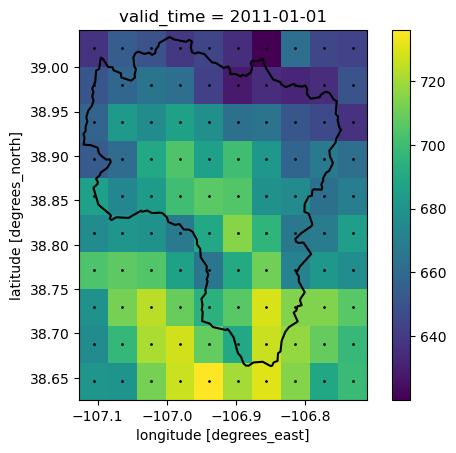

In [69]:
fig, ax = plt.subplots()
# pres_era5_ds.isel(valid_time=0).plot(ax=ax)
surface_pressure_ds.isel(valid_time=0).plot(ax=ax)
basin_gdf.boundary.plot(ax=ax, color='black')
# plot all lon_gridmet and lat_gridmet points
plt.scatter(lon_gridmet, lat_gridmet, s=1, color='black')
plt.scatter(points_era5[:,0], points_era5[:,1])